# Dask
Background: dask_tutorial in github

## Overview 
Dask provides multi-core and distributed parallel execution on larger-than-memory datasets.

We can think of Dask at a high and a low level

*  **High level collections:**  Dask provides high-level Array, Bag, and DataFrame
   collections that mimic NumPy, lists, and Pandas but can operate in parallel on
   datasets that don't fit into memory.  Dask's high-level collections are
   alternatives to NumPy and Pandas for large datasets.
*  **Low Level schedulers:** Dask provides dynamic task schedulers that
   execute task graphs in parallel.  These execution engines power the
   high-level collections mentioned above but can also power custom,
   user-defined workloads.  These schedulers are low-latency (around 1ms) and
   work hard to run computations in a small memory footprint.  Dask's
   schedulers are an alternative to direct use of `threading` or
   `multiprocessing` libraries in complex cases or other task scheduling
   systems like `Luigi` or `IPython parallel`.

Different users operate at different levels but it is useful to understand
both.

The Dask [use cases](https://stories.dask.org/en/latest/) provides a number of sample workflows where Dask should be a good fit.

## Dask Setup

### Install Dask
You can install dask with conda, with pip, or by installing from source.

#### Conda
Dask is installed by default in Anaconda. You can update Dask using the conda command:
conda install dask

#### Pip
pip install dask 

Dask has many ways of executing code in parallel. Let us start with dask.distributed.Client.

In [1]:
from dask.distributed import Client

# Let us start with number of workers as 4
client = Client(n_workers=4)

In [2]:
from time import sleep

def square(x):
    sleep(1)
    return x**2

def power(x,y):
    sleep(1)
    return x**y


In [3]:
%%time
x = square(2)
y = square(3)
z = power(x,y)

CPU times: user 164 ms, sys: 34.6 ms, total: 198 ms
Wall time: 3.01 s


## Parallelize code with `dask.delayed`

This is a simple way to use `dask` to parallelize existing codebases or build [complex systems](https://blog.dask.org/2018/02/09/credit-models-with-dask).  This will also help us to develop an understanding for later sections.

**Related Documentation**

* [Delayed documentation](https://docs.dask.org/en/latest/delayed.html)
* [Delayed screencast](https://www.youtube.com/watch?v=SHqFmynRxVU)
* [Delayed API](https://docs.dask.org/en/latest/delayed-api.html)
* [Delayed examples](https://examples.dask.org/delayed.html)
* [Delayed best practices](https://docs.dask.org/en/latest/delayed-best-practices.html)

In [4]:
from dask import delayed 

In [5]:
%%time
# This runs immediately, all it does is build a graph

x = delayed(square)(2)
y = delayed(square)(3)
z = delayed(power)(x, y)

CPU times: user 1.29 ms, sys: 1.31 ms, total: 2.6 ms
Wall time: 1.71 ms


In [6]:
%%time
z.compute()

CPU times: user 134 ms, sys: 27.1 ms, total: 161 ms
Wall time: 2.04 s


262144

In [7]:
type(z)

dask.delayed.Delayed

In [8]:
z

Delayed('power-ee5a7824-77b0-4589-9b0f-51fa60075720')

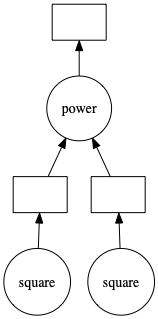

In [9]:
z.visualize()

## Parallelize a for-loop

In [10]:
def double(x):
    sleep(1)
    return 2 * x

def is_even(x):
    return not x % 2

data = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

In [11]:
%%time
# Sequential code

results = []
for x in data:
    if is_even(x):
        y = square(x)
    else:
        y = power(x, 3)
    results.append(y)
    
total = sum(results)
print(total)

1445
CPU times: user 545 ms, sys: 111 ms, total: 655 ms
Wall time: 10 s


Use delayed

In [12]:
results = []
for x in data:
    if is_even(x):  # even
        y = delayed(square)(x)
    else:          # odd
        y = delayed(power)(x, 3)
    results.append(y)
    
total = delayed(sum)(results)

In [13]:
%time total.compute()

CPU times: user 131 ms, sys: 26.7 ms, total: 157 ms
Wall time: 2.04 s


1445

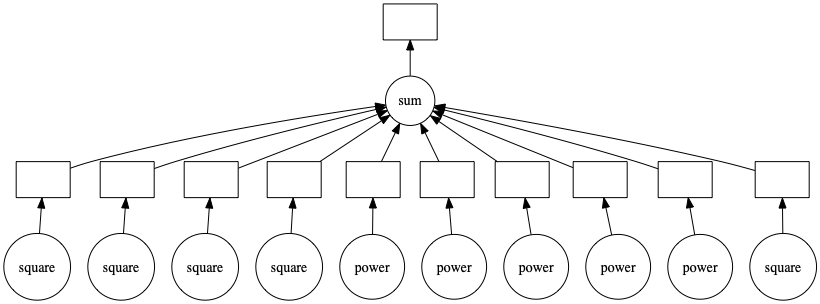

In [14]:
total.visualize()

## Parallze Pandas Groupby Reduction Example

Read several CSV files and perform a groupby operation in parallel.  We are given sequential code to do this and parallelize it with `dask.delayed`.

## Create data

Download and extract some historical flight data for flights out of NYC between 1990 and 2000. The data is originally from [here](http://stat-computing.org/dataexpo/2009/the-data.html).

In [15]:

%run prep.py -d flights

In [16]:
import os
sorted(os.listdir(os.path.join('../data', 'nycflights')))

['1990.csv',
 '1991.csv',
 '1992.csv',
 '1993.csv',
 '1994.csv',
 '1995.csv',
 '1996.csv',
 '1997.csv',
 '1998.csv',
 '1999.csv']

In [17]:
import pandas as pd
df = pd.read_csv(os.path.join('../data', 'nycflights', '1990.csv'))
df.head()

,Year,Month,DayofMonth,DayOfWeek,DepTime,CRSDepTime,ArrTime,CRSArrTime,UniqueCarrier,FlightNum,...,AirTime,ArrDelay,DepDelay,Origin,Dest,Distance,TaxiIn,TaxiOut,Cancelled,Diverted
0,1990,1,1,1,1621.0,1540,1747.0,1701,US,33,...,NaN,46.0,41.0,EWR,PIT,319.0,NaN,NaN,0,0
1,1990,1,2,2,1547.0,1540,1700.0,1701,US,33,...,NaN,-1.0,7.0,EWR,PIT,319.0,NaN,NaN,0,0
2,1990,1,3,3,1546.0,1540,1710.0,1701,US,33,...,NaN,9.0,6.0,EWR,PIT,319.0,NaN,NaN,0,0
3,1990,1,4,4,1542.0,1540,1710.0,1701,US,33,...,NaN,9.0,2.0,EWR,PIT,319.0,NaN,NaN,0,0
4,1990,1,5,5,1549.0,1540,1706.0,1701,US,33,...,NaN,5.0,9.0,EWR,PIT,319.0,NaN,NaN,0,0


In [18]:
df.dtypes

Year                   int64
Month                  int64
DayofMonth             int64
DayOfWeek              int64
DepTime              float64
CRSDepTime             int64
ArrTime              float64
CRSArrTime             int64
UniqueCarrier         object
FlightNum              int64
TailNum              float64
ActualElapsedTime    float64
CRSElapsedTime         int64
AirTime              float64
ArrDelay             float64
DepDelay             float64
Origin                object
Dest                  object
Distance             float64
TaxiIn               float64
TaxiOut              float64
Cancelled              int64
Diverted               int64
dtype: object

In [19]:
df.Origin.unique()

array(['EWR', 'LGA', 'JFK'], dtype=object)

In [20]:
# Mean departure delay per-airport for one year
df.groupby('Origin').DepDelay.mean()

Origin
EWR     9.168411
JFK    11.857274
LGA     8.560045
Name: DepDelay, dtype: float64

### Sequential code: Mean Departure Delay Per Airport

In [21]:
from glob import glob
filenames = sorted(glob(os.path.join('../data', 'nycflights', '*.csv')))

In [22]:
%%time

sums = []
counts = []
for fn in filenames:
    # Read in file
    df = pd.read_csv(fn)
    
    # Groupby origin airport
    by_origin = df.groupby('Origin')
    
    # Sum of all departure delays by origin
    total = by_origin.DepDelay.sum()
    
    # Number of flights by origin
    count = by_origin.DepDelay.count()
    
    # Save the intermediates
    sums.append(total)
    counts.append(count)

# Combine intermediates to get total mean-delay-per-origin
total_delays = sum(sums)
n_flights = sum(counts)
mean = total_delays / n_flights

CPU times: user 3.81 s, sys: 758 ms, total: 4.57 s
Wall time: 4.51 s


In [23]:
mean

Origin
EWR    10.295469
JFK    10.351299
LGA     7.431142
Name: DepDelay, dtype: float64

## Parallelize: Mean Departure Delay Per Airport

In [24]:
from dask import compute

In [25]:
%%time

# copied sequential code

sums = []
counts = []
for fn in filenames:
    # Read in file
    df = pd.read_csv(fn)
    
    # Groupby origin airport
    by_origin = df.groupby('Origin')
    
    # Sum of all departure delays by origin
    total = by_origin.DepDelay.sum()
    
    # Number of flights by origin
    count = by_origin.DepDelay.count()
    
    # Save the intermediates
    sums.append(total)
    counts.append(count)

# Combine intermediates to get total mean-delay-per-origin
total_delays = sum(sums)
n_flights = sum(counts)
mean = total_delays / n_flights

CPU times: user 3.88 s, sys: 752 ms, total: 4.64 s
Wall time: 4.57 s


In [26]:
mean

Origin
EWR    10.295469
JFK    10.351299
LGA     7.431142
Name: DepDelay, dtype: float64

In [27]:
%%time

# This is just one possible solution, there are
# several ways to do this using `delayed`

sums = []
counts = []
for fn in filenames:
    # Read in file
    df = delayed(pd.read_csv)(fn)

    # Groupby origin airport
    by_origin = df.groupby('Origin')

    # Sum of all departure delays by origin
    total = by_origin.DepDelay.sum()

    # Number of flights by origin
    count = by_origin.DepDelay.count()

    # Save the intermediates
    sums.append(total)
    counts.append(count)

# Compute the intermediates
sums, counts = compute(sums, counts)

# Combine intermediates to get total mean-delay-per-origin
total_delays = sum(sums)
n_flights = sum(counts)
mean = total_delays / n_flights

CPU times: user 134 ms, sys: 24 ms, total: 158 ms
Wall time: 1.89 s


In [28]:
mean

Origin
EWR    10.295469
JFK    10.351299
LGA     7.431142
Name: DepDelay, dtype: float64

## Close the Client

In [29]:
client.close()

# Lazy Execution

In [30]:
%run prep.py -d accounts

In [31]:
import pandas as pd
import os
filenames = [os.path.join('../data', 'accounts.%d.csv' % i) for i in [0, 1, 2]]
filenames

['../data/accounts.0.csv', '../data/accounts.1.csv', '../data/accounts.2.csv']

In [32]:
%%time

# normal, sequential code
a = pd.read_csv(filenames[0])
b = pd.read_csv(filenames[1])
c = pd.read_csv(filenames[2])

na = len(a)
nb = len(b)
nc = len(c)

total = sum([na, nb, nc])
print(total)

3000000
CPU times: user 565 ms, sys: 119 ms, total: 683 ms
Wall time: 696 ms


In [33]:

delayed_read_csv = delayed(pd.read_csv)
a = delayed_read_csv(filenames[0])
b = delayed_read_csv(filenames[1])
c = delayed_read_csv(filenames[2])

delayed_len = delayed(len)
na = delayed_len(a)
nb = delayed_len(b)
nc = delayed_len(c)

delayed_sum = delayed(sum)

total = delayed_sum([na, nb, nc])
%time print(total.compute())


## concise version
csvs = [delayed(pd.read_csv)(fn) for fn in filenames]
lens = [delayed(len)(csv) for csv in csvs]
total = delayed(sum)(lens)
%time print(total.compute())

3000000
CPU times: user 599 ms, sys: 165 ms, total: 764 ms
Wall time: 368 ms
3000000
CPU times: user 611 ms, sys: 173 ms, total: 784 ms
Wall time: 376 ms


In [34]:
import sources
sources.lazy_url

'http://www.google.com'

In [35]:
import threading
import queue
import urllib

def get_webdata(url, q):
    u = urllib.request.urlopen(url)
    # raise ValueError
    q.put(u.read())

q = queue.Queue()
t = threading.Thread(target=get_webdata, args=(sources.lazy_url, q))
t.start()

In [36]:
# fetch result back into this thread. If the worker thread is not done, this would wait.
q.get()

b'<!doctype html><html itemscope="" itemtype="http://schema.org/WebPage" lang="en"><head><meta content="Search the world\'s information, including webpages, images, videos and more. Google has many special features to help you find exactly what you\'re looking for." name="description"><meta content="noodp" name="robots"><meta content="text/html; charset=UTF-8" http-equiv="Content-Type"><meta content="/images/branding/googleg/1x/googleg_standard_color_128dp.png" itemprop="image"><title>Google</title><script nonce="iUEWp3NEWIjiEKuZmzxDyw==">(function(){window.google={kEI:\'OGdyYIGVDYHrtQaf77nwBA\',kEXPI:\'0,1302536,56873,954,5105,206,4804,2316,383,246,5,1129,225,4936,314,6386,1116130,1233,1196539,510,44,328941,51224,16114,17444,11240,9188,8384,4859,1361,9290,3025,4743,6,12835,4020,978,13228,2054,920,873,10622,1142,13385,235,4282,2778,919,2277,8,4389,1279,2212,239,291,149,1103,840,517,1466,56,157,4101,109,3405,606,2023,2297,4269,328,1284,8789,3227,1989,856,7,12354,5096,7876,4929,108,1483,

## Bag: Parallel Lists for semi-structured data

Dask Bag implements operations like map, filter, fold, and groupby on collections of generic Python objects. It does this in parallel with a small memory footprint using Python iterators. It is similar to a parallel version of PyToolz or a Pythonic version of the PySpark RDD.

Dask-bag excels in processing data that can be represented as a sequence of arbitrary inputs. Sometimes its called as messy data. Messy data is often encountered at the beginning of data processing pipelines when large volumes of raw data are first consumed. The initial set of data might be JSON, CSV, XML, or any other format that does not enforce strict structure and datatypes.

### Create data

In [37]:
%run prep.py -d accounts

In [38]:
from dask.distributed import Client

client = Client(n_workers=4)

### Bag creation

In [39]:
# each element is an integer
import dask.bag as db
b = db.from_sequence([1, 2, 3, 4, 5, 6, 7, 8, 9, 10], npartitions=2)
b.take(3)

(1, 2, 3)

In [40]:
import os
b = db.read_text(os.path.join('../data', 'accounts.*.json.gz'))
b.take(1)

('{"id": 0, "name": "Yvonne", "transactions": [{"transaction-id": 5486, "amount": 539}, {"transaction-id": 9572, "amount": 816}, {"transaction-id": 10229, "amount": 634}, {"transaction-id": 10377, "amount": 742}, {"transaction-id": 10561, "amount": 987}, {"transaction-id": 13498, "amount": 931}, {"transaction-id": 15436, "amount": 856}, {"transaction-id": 15784, "amount": 474}, {"transaction-id": 17645, "amount": 1013}, {"transaction-id": 48932, "amount": 655}, {"transaction-id": 50804, "amount": 772}, {"transaction-id": 59408, "amount": 656}, {"transaction-id": 60799, "amount": 702}, {"transaction-id": 63352, "amount": 631}, {"transaction-id": 70988, "amount": 746}, {"transaction-id": 71551, "amount": 889}, {"transaction-id": 72972, "amount": 855}, {"transaction-id": 80384, "amount": 728}, {"transaction-id": 81706, "amount": 568}, {"transaction-id": 86115, "amount": 762}, {"transaction-id": 93311, "amount": 685}]}\n',)

## Arrays

Dask array provides a parallel, larger-than-memory, n-dimensional array using blocked algorithms. Simply put: distributed Numpy.


> Parallel: Uses all of the cores on your computer

> Larger-than-memory:  Lets you work on datasets that are larger than your available memory by breaking up your array into many small pieces, operating on those pieces in an order that minimizes the memory footprint of your computation, and effectively streaming data from disk.

> Blocked Algorithms:  Perform large computations by performing many smaller computations

### Dataframes

In [42]:
%run prep.py -d flights

In [43]:
from dask.distributed import Client

client = Client(n_workers=4)

/Users/lalithap/anaconda3/envs/learn-env/lib/python3.8/site-packages/distributed/node.py:151: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 60825 instead
  warnings.warn(


In [46]:
from prep import accounts_csvs
accounts_csvs()

import os
import dask
filename = os.path.join('../data', 'accounts.*.csv')
filename

'../data/accounts.*.csv'

In [47]:
import dask.dataframe as dd
df = dd.read_csv(filename)
df.head()

,id,names,amount
0,295,Edith,2974
1,303,Ray,1220
2,18,George,160
3,371,Alice,234
4,211,Oliver,341


In [48]:
# load and count number of rows
len(df)

3000000

In [50]:
df = dd.read_csv(os.path.join('../data', 'nycflights', '*.csv'),
                 parse_dates={'Date': [0, 1, 2]})

In [51]:
df

,Date,DayOfWeek,DepTime,CRSDepTime,ArrTime,CRSArrTime,UniqueCarrier,FlightNum,TailNum,ActualElapsedTime,CRSElapsedTime,AirTime,ArrDelay,DepDelay,Origin,Dest,Distance,TaxiIn,TaxiOut,Cancelled,Diverted
npartitions=10,,,,,,,,,,,,,,,,,,,,,
,datetime64[ns],int64,float64,int64,float64,int64,object,int64,float64,float64,int64,float64,float64,float64,object,object,float64,float64,float64,int64,int64
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...


In [52]:
df.head()

,Date,DayOfWeek,DepTime,CRSDepTime,ArrTime,CRSArrTime,UniqueCarrier,FlightNum,TailNum,ActualElapsedTime,...,AirTime,ArrDelay,DepDelay,Origin,Dest,Distance,TaxiIn,TaxiOut,Cancelled,Diverted
0,1990-01-01,1,1621.0,1540,1747.0,1701,US,33,NaN,86.0,...,NaN,46.0,41.0,EWR,PIT,319.0,NaN,NaN,0,0
1,1990-01-02,2,1547.0,1540,1700.0,1701,US,33,NaN,73.0,...,NaN,-1.0,7.0,EWR,PIT,319.0,NaN,NaN,0,0
2,1990-01-03,3,1546.0,1540,1710.0,1701,US,33,NaN,84.0,...,NaN,9.0,6.0,EWR,PIT,319.0,NaN,NaN,0,0
3,1990-01-04,4,1542.0,1540,1710.0,1701,US,33,NaN,88.0,...,NaN,9.0,2.0,EWR,PIT,319.0,NaN,NaN,0,0
4,1990-01-05,5,1549.0,1540,1706.0,1701,US,33,NaN,77.0,...,NaN,5.0,9.0,EWR,PIT,319.0,NaN,NaN,0,0


In [55]:
df = dd.read_csv(os.path.join('../data', 'nycflights', '*.csv'),
                 parse_dates={'Date': [0, 1, 2]},
                 dtype={'TailNum': str,
                        'CRSElapsedTime': float,
                        'Cancelled': bool})

In [56]:
df.tail()

,Date,DayOfWeek,DepTime,CRSDepTime,ArrTime,CRSArrTime,UniqueCarrier,FlightNum,TailNum,ActualElapsedTime,...,AirTime,ArrDelay,DepDelay,Origin,Dest,Distance,TaxiIn,TaxiOut,Cancelled,Diverted
269176,1999-12-27,1,1645.0,1645,1830.0,1901,UA,1753,N516UA,225.0,...,205.0,-31.0,0.0,LGA,DEN,1619.0,7.0,13.0,False,0
269177,1999-12-28,2,1726.0,1645,1928.0,1901,UA,1753,N504UA,242.0,...,214.0,27.0,41.0,LGA,DEN,1619.0,5.0,23.0,False,0
269178,1999-12-29,3,1646.0,1645,1846.0,1901,UA,1753,N592UA,240.0,...,220.0,-15.0,1.0,LGA,DEN,1619.0,5.0,15.0,False,0
269179,1999-12-30,4,1651.0,1645,1908.0,1901,UA,1753,N575UA,257.0,...,233.0,7.0,6.0,LGA,DEN,1619.0,5.0,19.0,False,0
269180,1999-12-31,5,1642.0,1645,1851.0,1901,UA,1753,N539UA,249.0,...,232.0,-10.0,-3.0,LGA,DEN,1619.0,6.0,11.0,False,0


In [57]:
%time df.DepDelay.max().compute()

CPU times: user 171 ms, sys: 39.1 ms, total: 210 ms
Wall time: 2.3 s


1435.0

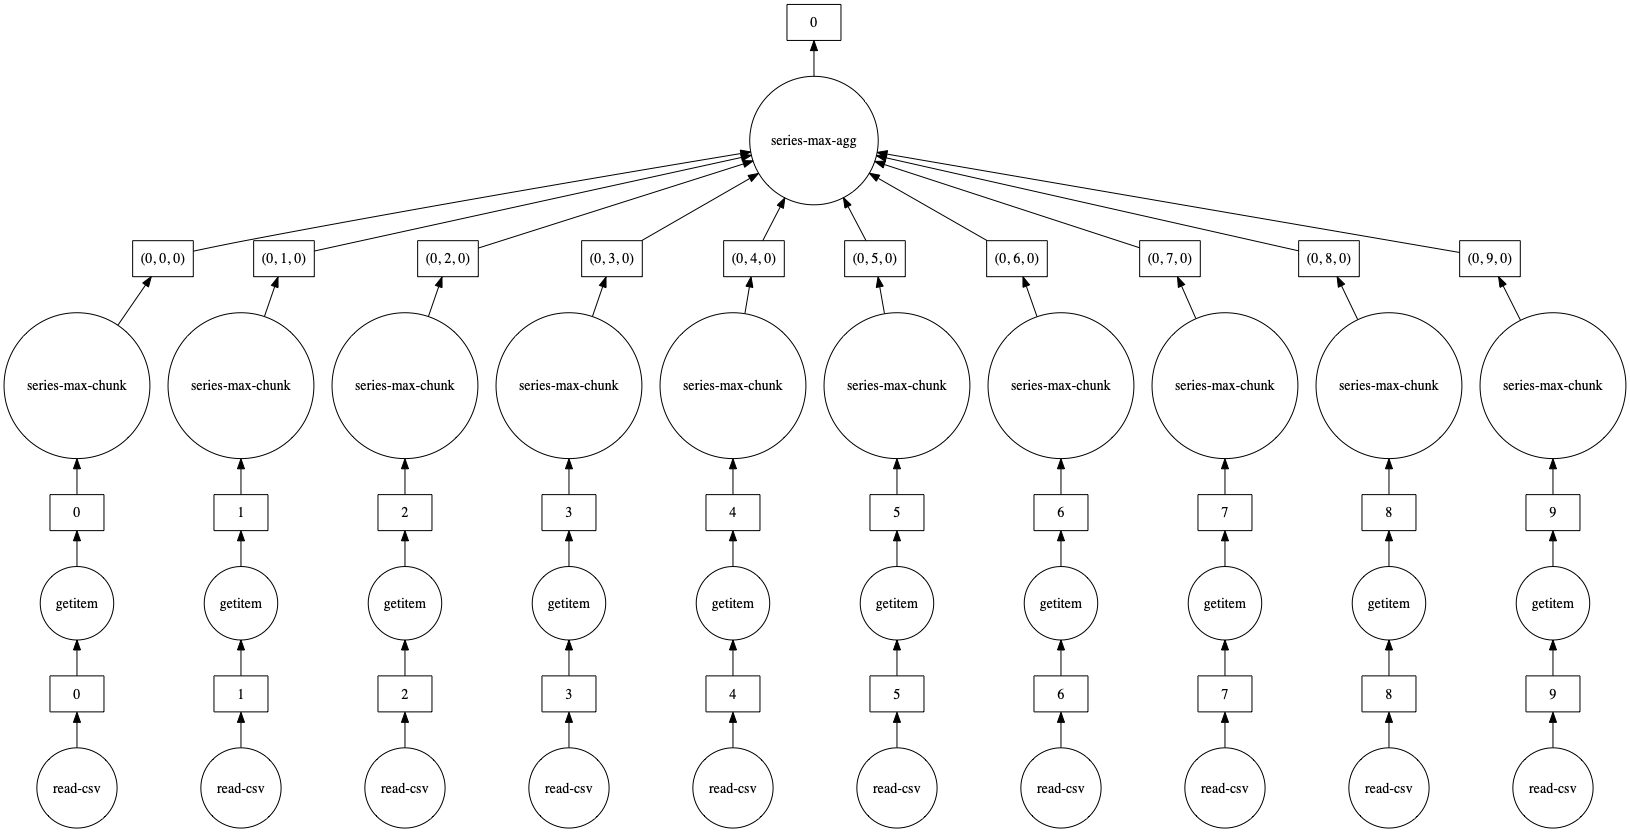

In [58]:
df.DepDelay.max().visualize()

In [59]:
len(df)

2611892

In [60]:
len(df[~df.Cancelled])

2540961

In [61]:
df[~df.Cancelled].groupby('Origin').Origin.count().compute()

Origin
EWR    1139451
JFK     427243
LGA     974267
Name: Origin, dtype: int64

In [62]:
df.groupby("Origin").DepDelay.mean().compute()

Origin
EWR    10.295469
JFK    10.351299
LGA     7.431142
Name: DepDelay, dtype: float64

In [63]:
df.groupby("DayOfWeek").DepDelay.mean().compute()

DayOfWeek
1     8.096565
2     8.149109
3     9.141912
4    10.538275
5    11.476687
6     7.824071
7     8.994296
Name: DepDelay, dtype: float64

In [64]:
non_cancelled = df[~df.Cancelled]
mean_delay = non_cancelled.DepDelay.mean()
std_delay = non_cancelled.DepDelay.std()

In [65]:
%%time

mean_delay_res = mean_delay.compute()
std_delay_res = std_delay.compute()

CPU times: user 303 ms, sys: 62.8 ms, total: 365 ms
Wall time: 3.97 s


In [66]:
%%time

mean_delay_res, std_delay_res = dask.compute(mean_delay, std_delay)

CPU times: user 193 ms, sys: 33.5 ms, total: 227 ms
Wall time: 2.27 s


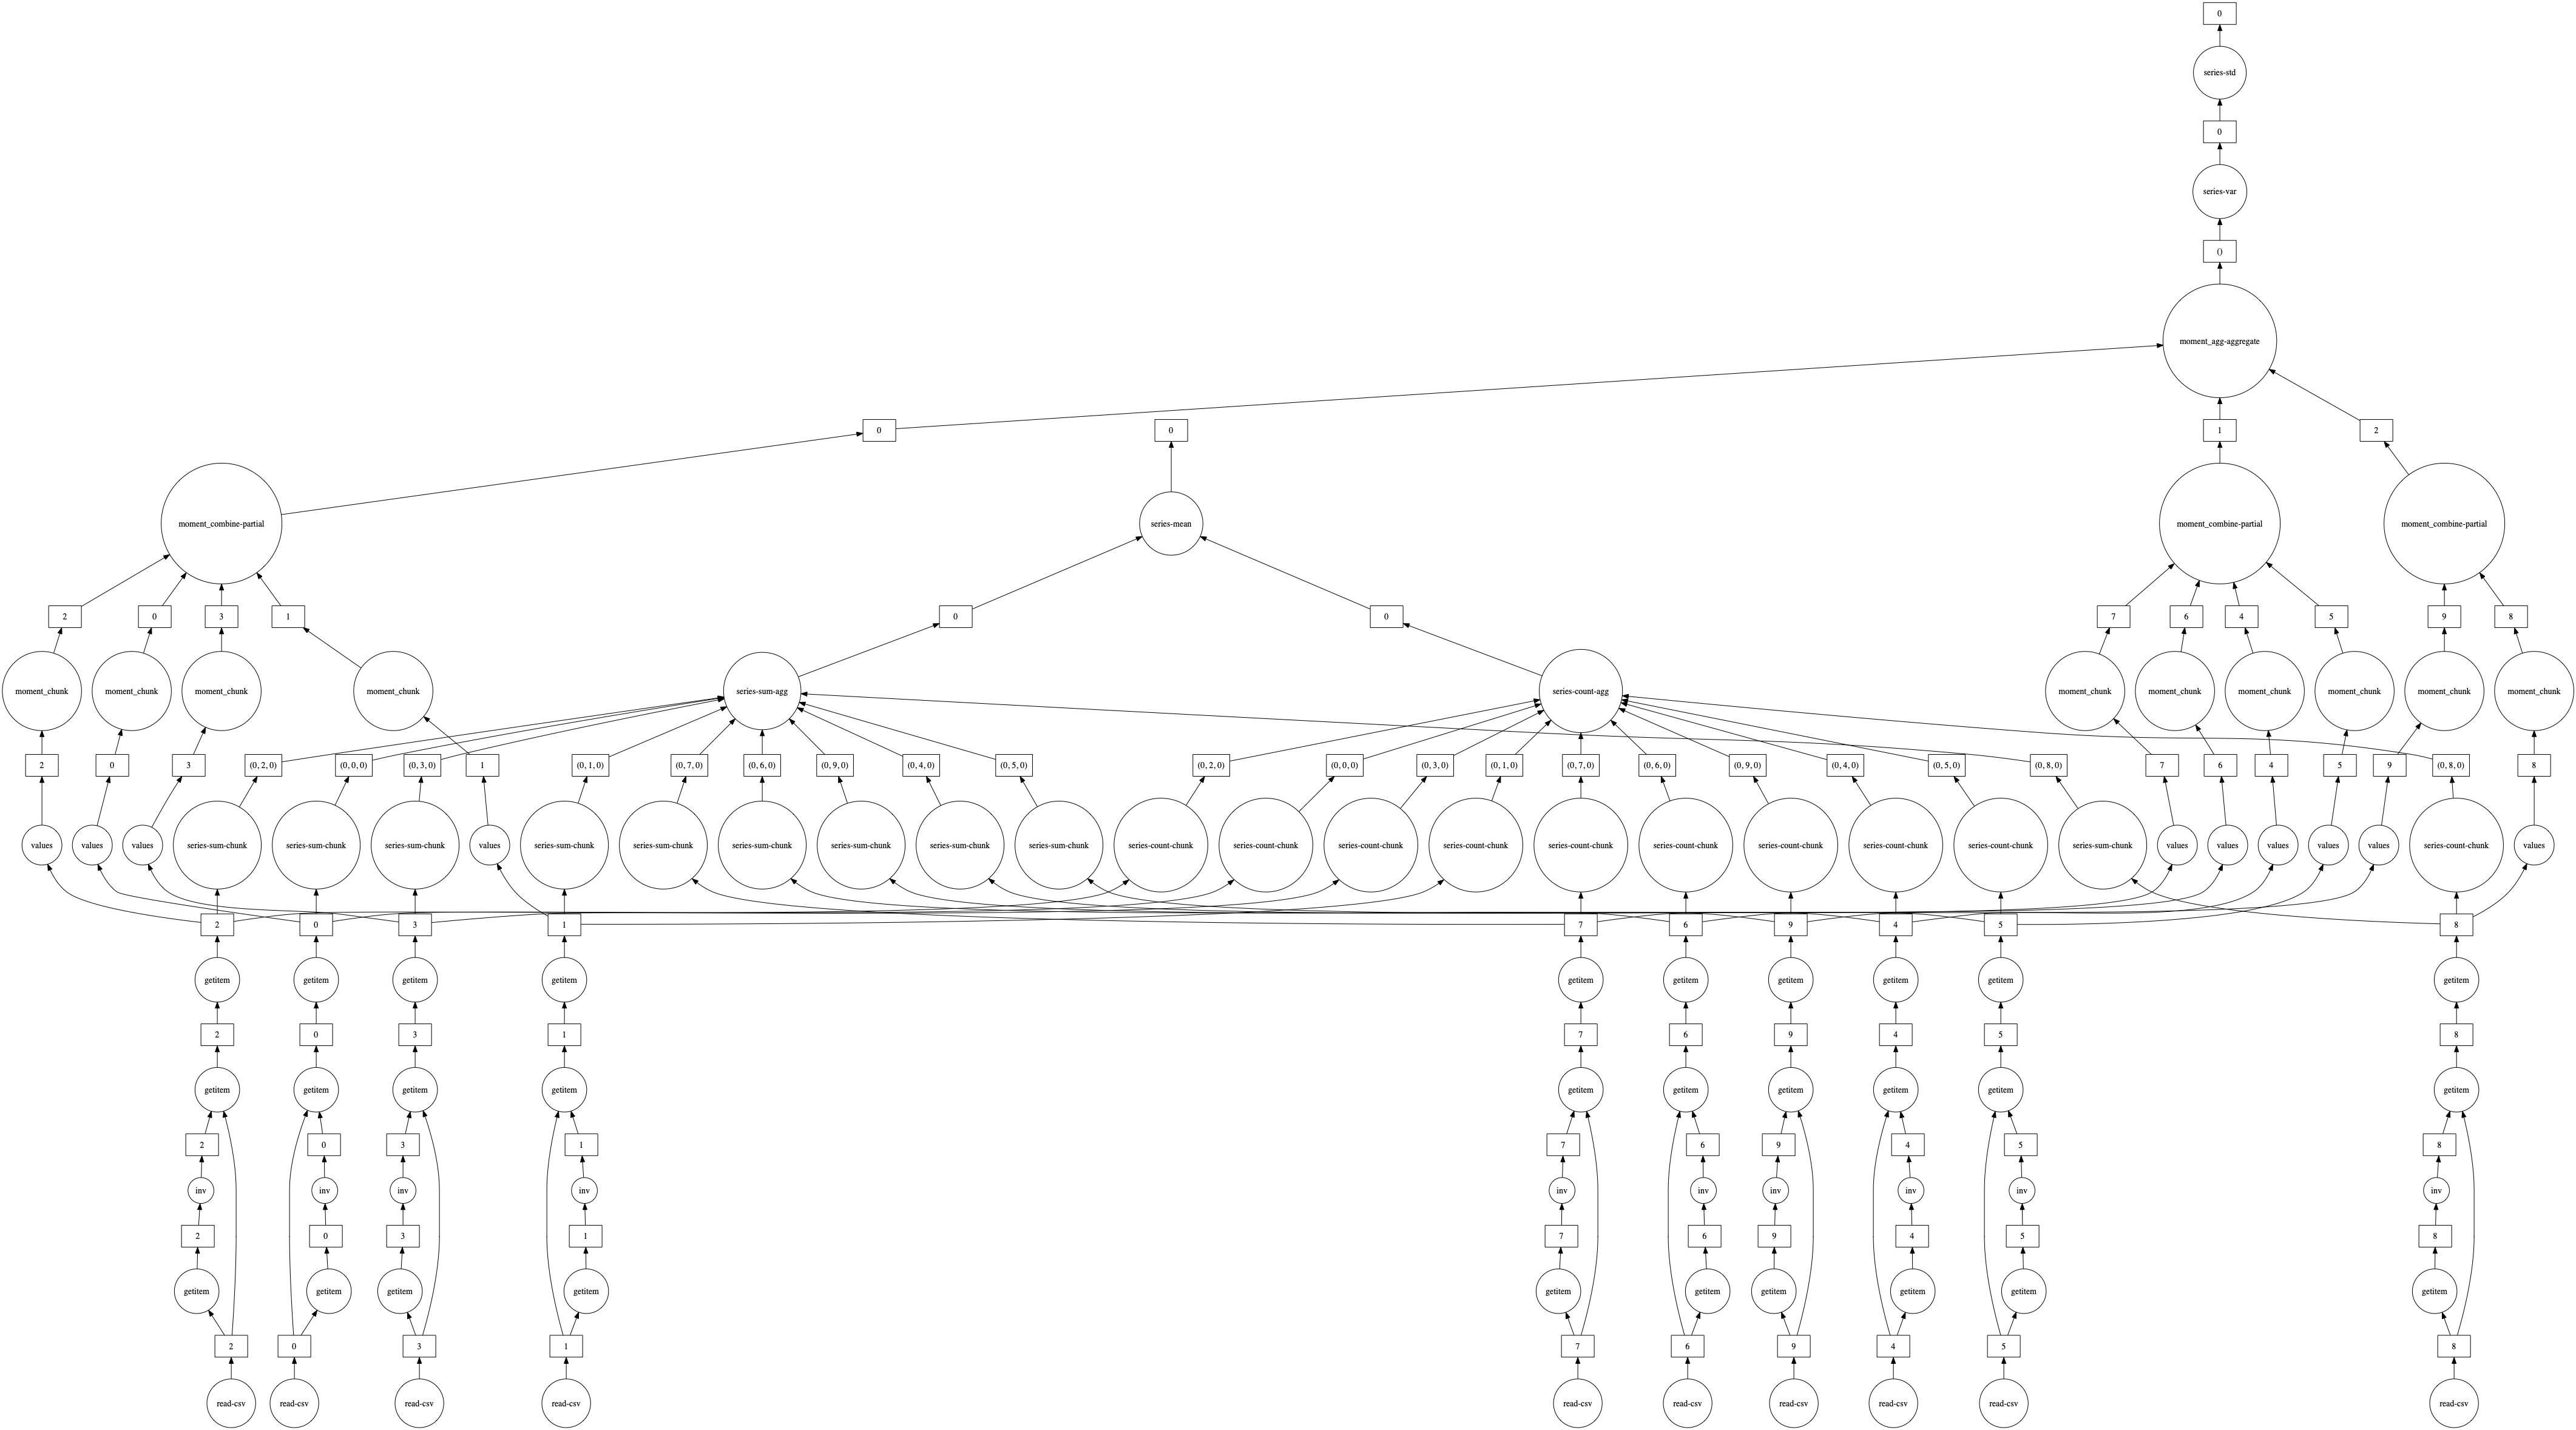

In [67]:
dask.visualize(mean_delay, std_delay)

In [68]:
crs_dep_time = df.CRSDepTime.head(10)
crs_dep_time

0    1540
1    1540
2    1540
3    1540
4    1540
5    1540
6    1540
7    1540
8    1540
9    1540
Name: CRSDepTime, dtype: int64

In [69]:
import pandas as pd

# Get the first 10 dates to complement our `crs_dep_time`
date = df.Date.head(10)

# Get hours as an integer, convert to a timedelta
hours = crs_dep_time // 100
hours_timedelta = pd.to_timedelta(hours, unit='h')

# Get minutes as an integer, convert to a timedelta
minutes = crs_dep_time % 100
minutes_timedelta = pd.to_timedelta(minutes, unit='m')

# Apply the timedeltas to offset the dates by the departure time
departure_timestamp = date + hours_timedelta + minutes_timedelta
departure_timestamp

0   1990-01-01 15:40:00
1   1990-01-02 15:40:00
2   1990-01-03 15:40:00
3   1990-01-04 15:40:00
4   1990-01-05 15:40:00
5   1990-01-06 15:40:00
6   1990-01-07 15:40:00
7   1990-01-08 15:40:00
8   1990-01-09 15:40:00
9   1990-01-10 15:40:00
dtype: datetime64[ns]

In [70]:
help(df.CRSDepTime.map_partitions)

Help on method map_partitions in module dask.dataframe.core:

map_partitions(func, *args, **kwargs) method of dask.dataframe.core.Series instance
    Apply Python function on each DataFrame partition.
    
    Note that the index and divisions are assumed to remain unchanged.
    
    Parameters
    ----------
    func : function
        Function applied to each partition.
    args, kwargs :
        Arguments and keywords to pass to the function. The partition will
        be the first argument, and these will be passed *after*. Arguments
        and keywords may contain ``Scalar``, ``Delayed`` or regular
        python objects. DataFrame-like args (both dask and pandas) will be
        repartitioned to align (if necessary) before applying the function.
    meta : pd.DataFrame, pd.Series, dict, iterable, tuple, optional
        An empty ``pd.DataFrame`` or ``pd.Series`` that matches the dtypes
        and column names of the output. This metadata is necessary for
        many algorithm

In [71]:
hours = df.CRSDepTime // 100
# hours_timedelta = pd.to_timedelta(hours, unit='h')
hours_timedelta = hours.map_partitions(pd.to_timedelta, unit='h')

minutes = df.CRSDepTime % 100
# minutes_timedelta = pd.to_timedelta(minutes, unit='m')
minutes_timedelta = minutes.map_partitions(pd.to_timedelta, unit='m')

departure_timestamp = df.Date + hours_timedelta + minutes_timedelta

In [ ]:
departure_timestamp